In [1]:
## Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import dask.dataframe as dd
import dask_geopandas as dgpd
import statsmodels as sm
from statsmodels.formula.api import ols
from latlon_utils import get_climate, get_data_dir
import xarray as xr
import rioxarray
import cdsapi
import urllib3
import cartopy.crs as ccrs
import cartopy

# import powerlaw

analysis_dir = '/Volumes/thebe/Ch4/GSW_zonal_stats/HL/v3/'
# roi_pth = '/Volumes/thebe/PAD2019/classification_training/ROI-analysis/ROI-analysis_albers.shp' # for small UAVSAR rois
season = 'jja' # or 'ann'
maxArea = 5000 # km2 include only lakes less than this for calc

###### vars
''' Vars 'dataset', 'roi_region', 'run' are used to generate output filename.'''
###########
# HL vars
dataset = 'HL'
variables = {'id_':'Hylak_id', 'gridcell_':'BAWLDCell_', 'area_':'Shp_Area', 'long_':'BAWLDLong', 'lat_':'BAWLDLat'} # Note: need t o join in lat/long
gdf_pth = '/Volumes/thebe/Ch4/GSW_zonal_stats/HL/v3/HL_zStats_Oc_binned_jnBAWLD.shp' # HL clipped to BAWLD
# gdf_pth = '/Volumes/thebe/Ch4/GSW_zonal_stats/HL/v3/HL_zStats_Oc_binned_jnBAWLD_roiNAHL.shp' # HL clipped to BAWLD and WBD-NAHL
useROI = False
roi_region = 'BAWLD' #'WBD' # 'Baker' # PAD, Daring, YF
run=10
# roi_pth = '/Volumes/thebe/Other/Feng-High-res-inland-surface-water-tundra-boreal-NA/edk_out/WBD_convex_hull.shp' # for WBD roi
areaConversionFactor = 1 # because area already in m2
runNote = 'With ERA5'

################ auto update vars
#################################

## Def output paths
joined_clim_dir = os.path.join(analysis_dir, 'joined_climate', f'run{run:02}')
# summ_file_pth = os.path.join(joined_clim_dir, f'{dataset}_sub{roi_region}_clim_summ.csv')
# logFile_pth = os.path.join(joined_clim_dir, f'logfile_run{run:02}.txt')

## Make dirs
os.makedirs(joined_clim_dir, exist_ok=True)

/var/folders/rv/sn0kln2103b9fs4xl56n3w7w0000gn/T/ipykernel_9142/477152975.py:7: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas 

# BAWLD-CH4 regression

In [69]:
## Load
df = pd.read_csv('/Volumes/thebe/Other/Kuhn-olefeldt-BAWLD/BAWLD-CH4/data/ek_out/BAWLD_CH4_Aquatic.csv', 
    encoding = "ISO-8859-1", dtype={'CH4.E.FLUX ':'float'}, na_values='-')
len0 = len(df)

## Add total lake flux column (to match LSD.py)
df['CH4.E.FLUX'].fillna(df['CH4.D.FLUX']*1.2, inplace=True) # Placeholder until I find ratio
df['CH4.D.FLUX'].fillna(df['CH4.E.FLUX']/1.2, inplace=True) # Placeholder until I find ratio
df['CH4.DE.FLUX'] = df['CH4.D.FLUX'] + df['CH4.E.FLUX']

## Filter and pre-process
df.dropna(subset=['SA', 'CH4.DE.FLUX', 'LAT', 'LONG', 'YEAR.S','MONTH'], inplace=True) # 'TEMP'

## if I want transformed y as its own var
df['CH4.D.FLUX.LOG'] = np.log10(df['CH4.D.FLUX']+1) 

## print filtering
len1 = len(df)
print(f'Filtered out {len0-len1} values ({len1} remaining).')
print(f'Variables: {df.columns}')

## View
df.head(2)


Filtered out 190 values (363 remaining).
Variables: Index(['ID', 'NUM', 'STUDY', 'DATASET', 'YEAR', 'COUNTRY', 'SITE',
       'NUMBER.LAKES', 'LAT', 'LONG', 'ECOREGION', 'PERMA.ZONE', 'LAKE.TYPE',
       'BOTTOM', 'TALIK', 'SA', 'DEPTH', 'SEASON', 'YEAR.S', 'MONTH',
       'PATHWAY', 'D.METHOD', 'K600_EQ', 'K_REF', 'E.METHOD', 'E.LOCATION',
       'S.METHOD', 'D.DAYS', 'E.DAYS', 'LENGTH', 'CH4.D.FLUX', 'CH4.E.FLUX',
       'Seasonal.Diff.Flux', 'Seasonal.Ebul', 'Seasonal.Storage', 'IBS',
       'TEMP', 'DOC', 'PH', 'ICEFREE.DAYS', 'CLASS', 'SIZE', 'TYPE',
       'CD_Pcp_An', 'BIOME', 'GRID_T', 'NOTES', 'DOI', 'CH4.DE.FLUX',
       'CH4.D.FLUX.LOG'],
      dtype='object')


,ID,NUM,STUDY,DATASET,YEAR,COUNTRY,SITE,NUMBER.LAKES,LAT,LONG,...,CLASS,SIZE,TYPE,CD_Pcp_An,BIOME,GRID_T,NOTES,DOI,CH4.DE.FLUX,CH4.D.FLUX.LOG
0,1,1,Bartlett et al. 1992,WIK,1992,USA,Large lakes,20.0,60.46,-161.45,...,LL,L,NaN,522.45,11.0,-0.006,NaN,https://doi.org/10.1029/91JD00610,8.36,0.681241
1,2,1,Bartlett et al. 1992,WIK,1992,USA,Small lakes,20.0,60.46,-161.45,...,MLPe,M,Pe,522.45,11.0,-0.006,NaN,https://doi.org/10.1029/91JD00610,189.00,1.892095


## Exploratory data analysis   

### Plot metadata

Text(0.5, 0, 'Mg CH4 / m2 /day')

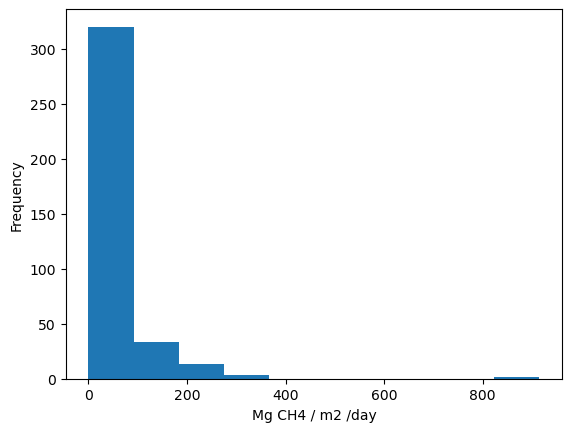

In [107]:
## Viz plot
df['CH4.D.FLUX'].plot.hist()
plt.xlabel('Mg CH4 / m2 /day')

<Axes: xlabel='GRID_T', ylabel='CH4.DE.FLUX'>

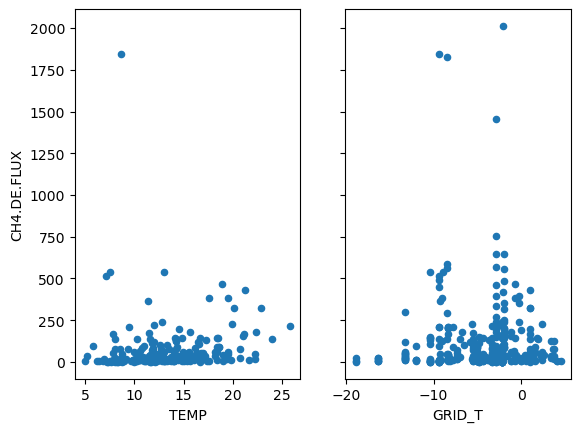

In [108]:
## Plot
_, ax = plt.subplots(1,2, sharey=True)
# df1.plot.scatter(x='TEMP', y='GRID_T')
df.plot.scatter(x='TEMP', y='CH4.DE.FLUX', ax=ax[0])
df.plot.scatter(x='GRID_T', y='CH4.DE.FLUX', ax=ax[1])

In [109]:
## How many missing entries for temp and GRID_T?
np.sum(np.isnan(df.TEMP))
np.sum(np.isin(df.MONTH, ''))
np.sum(np.isnan(df.GRID_T))

5

<Axes: ylabel='Frequency'>

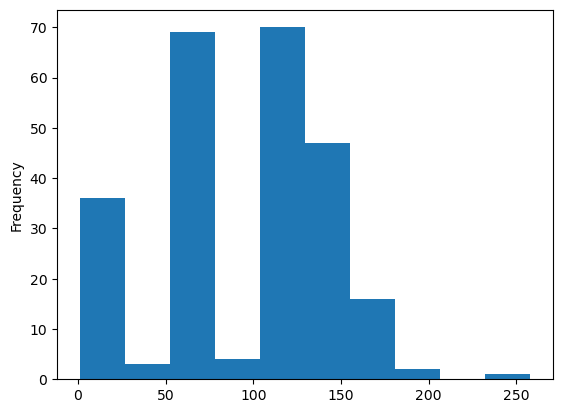

In [110]:
## How long were most studies?
df.LENGTH.plot.hist()

.: Most studies lasted < 150 days with <= 3 measurements. So modeled monthly air temp would be hard to compute, unless I take the middle month or average of months.

/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='D.DAYS', ylabel='Count'>

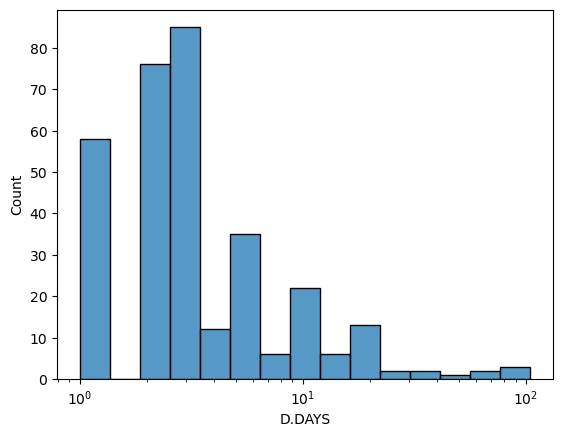

In [111]:
sns.histplot(df, x='D.DAYS', log_scale=10)

In [7]:
## How many unique years and months in BAWLD?
unq_yrs = np.unique(df[['YEAR']])
unq_yrs

array([1992, 1994, 1995, 1998, 1999, 2001, 2002, 2003, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2016, 2017, 2018, 2019, 2020])

In [8]:
df[['LAT','LONG']]
df[['YEAR','MONTH']]

,YEAR,MONTH
0,1992,July-August
1,1992,July-August
2,1992,July-August
17,2016,July
18,2016,July
...,...,...
540,2010,June-September
542,2013,June-Sept
543,2013,June-Sept
544,2013,June-Sept


## Find D vs E ratio

# Download climate data using csdapi

In [9]:
# Suppress only InsecureRequestWarning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

## Use Climate Data Services API
cds = cdsapi.Client()
cds_dir = '/Volumes/thebe/Ch4/ERA5/cds'
cds_pth = os.path.join(cds_dir, "download.netcdf.zip") # test.grib causes xarray loading issues...
!rm {os.path.join(cds_dir, 'data.nc')} # to avoid unzip question prompt to overwrite
# ERA5-land monthly data

# dataset you want to read
dataset = 'reanalysis-era5-land-monthly-means' # reanalysis-era5-pressure-levels-monthly-means 
years = list(map(str, np.concatenate((unq_yrs, [2022]))))

# api parameters 
params = {
    "format": "netcdf",
    "product_type": "monthly_averaged_reanalysis",
    "variable": ['lake_bottom_temperature', 'skin_temperature', 'soil_temperature_level_4', 'soil_temperature_level_1', '2m_temperature'], # K - 273.15
    'year': years, # 2022
    'month':["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"],
    "time": "00:00", 
    'format': 'netcdf.zip', # output.grib
    "grid": [0.25, 0.1], # lon lat
    "area": [90, -180, 50, 180],
    }

rm: /Volumes/thebe/Ch4/ERA5/cds/data.nc: No such file or directory


In [ ]:
# retrieves the path to the file (Can skip this cell)
fl = cds.retrieve(dataset, params, cds_pth)

# load into memory
# with urlopen(fl.location) as f:
#     ds = xr.open_dataset(f.read())

## Unzip and rename
!unzip {cds_pth} -d {cds_dir}
!mv {os.path.join(cds_dir, 'data.nc')}{os.path.join(cds_dir, 'temperatures.nc')}

In [10]:
## Load and view
da = xr.load_dataset(os.path.join(cds_dir, 'temperatures.nc'))
# da = xr.load_dataset(os.path.join(cds_dir, 'test.grib'), engine='cfgrib')

## Info
da

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 401, time: 288)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.9 89.8 89.7 ... 50.3 50.2 50.1 50.0
  * time       (time) datetime64[ns] 1992-01-01 1992-02-01 ... 2022-12-01
Data variables:
    lblt       (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    skt        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    stl4       (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    stl1       (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    t2m        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2023-09-13 15:46:13 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

Text(0.5, 1.0, 'ERA5 t2m')

/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


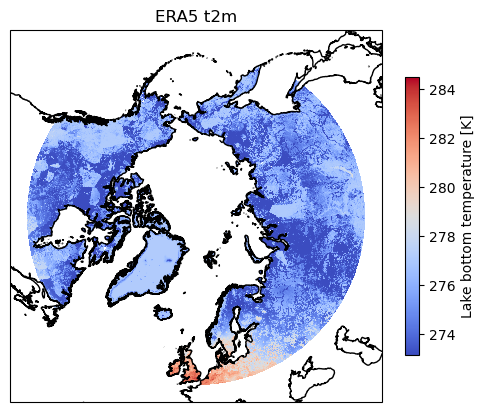

In [11]:
## View
variable = 't2m' # 'lblt' 'skt', 'stl4', 'stl1', 't2m'
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.coastlines(resolution="10m")

da.lblt.sel(time='2022-11-01').plot(cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree(), cbar_kwargs={"shrink": 0.6}) # geographic coords
plt.title(f"ERA5 {variable}")

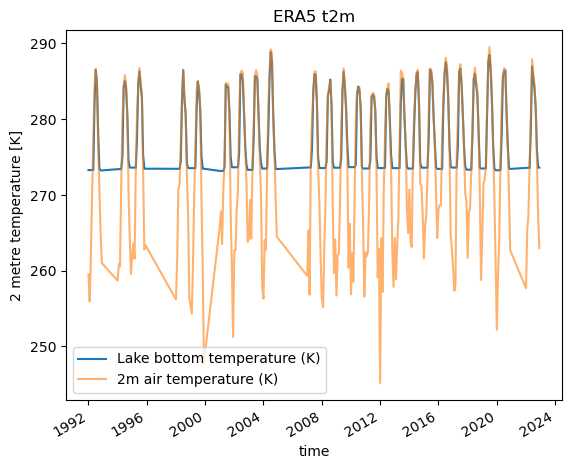

In [12]:
## Time series plot
fig, ax = plt.subplots()
da.lblt.sel(latitude=[60.460], longitude=[-161.450], method='nearest').plot(ax=ax, label='Lake bottom temperature (K)') # geographic coords
da.t2m.sel(latitude=[60.460], longitude=[-161.450], method='nearest').plot(ax=ax, label='2m air temperature (K)', alpha=0.6) # geographic coords
ax.set_title(f"ERA5 {variable}")
ax.legend()

In [49]:
## Practice loading from coords
da.lblt.sel(latitude=[60.460], longitude=[-161.450], time='2022-05-01', method='nearest')

<xarray.DataArray 'lblt' (latitude: 1, longitude: 1)>
array([[278.67072]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -161.5
  * latitude   (latitude) float32 60.5
    time       datetime64[ns] 2022-05-01
Attributes:
    units:      K
    long_name:  Lake bottom temperature

# BAWLD Regression

## Initial tests with builtin data

In [ ]:
## Linear models (regression) v0
formula1 = "np.log10(Q('CH4.DE.FLUX') + 0.01) ~ np.log10(SA) + TEMP" # 'Seasonal.Diff.Flux' 'CH4.D.FLUX'
model1 = ols(formula=formula1, data=dff).fit() # uses water temp
formula2 = "np.log10(Q('CH4.DE.FLUX') + 0.01) ~ np.log10(SA) + GRID_T" # 'Seasonal.Diff.Flux' 'CH4.D.FLUX'
model2 = ols(formula=formula2, data=dff).fit() # uses MAAT
formula3 = "np.log10(Q('CH4.DE.FLUX') + 0.01) ~ np.log10(SA) + np.power(TEMP, 2)" # 'Seasonal.Diff.Flux' 'CH4.D.FLUX'
model3 = ols(formula=formula3, data=dff).fit() # uses MAAT

# print(f'R2: {model1.rsquared:0.3}')
model1.summary() # Their model uses 149 data points with adj r2 = 0.36

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     np.log10(Q('CH4.DE.FLUX') + 0.01)   R-squared:                       0.106
Model:                                           OLS   Adj. R-squared:                  0.099
Method:                                Least Squares   F-statistic:                     14.35
Date:                               Wed, 13 Sep 2023   Prob (F-statistic):           1.30e-06
Time:                                       10:58:46   Log-Likelihood:                -256.18
No. Observations:                                244   AIC:                             518.4
Df Residuals:                                    241   BIC:                             528.9
Df Model:                                          2                                         
Covariance Type:                           nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.5402      0.161      3.345      0.001       0.222       0.858
np.log10(SA)    -0.0887      0.037     -2.378      0.018      -0.162      -0.015
TEMP             0.0507      0.011      4.506      0.000       0.029       0.073
==============================================================================
Omnibus:                       77.880   Durbin-Watson:                   1.625
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              407.419
Skew:                          -1.156   Prob(JB):                     3.39e-89
Kurtosis:                       8.893   Cond. No.                         51.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
## Compare model using water temp vs MAAT. First column is after filtering by TEMP and ice-free. Second column is without and shows less difference bw variable.
model1.rsquared # 0.115 # 0.106 # water temp
model2.rsquared # 0.046 # 0.109 # MAAT
model3.rsquared # 0.116 # 0.108 # water temp squared - hardly an improvement! Justification for linear.
# TODO: model that uses monthly or daily air temp!

0.10640152655941582

## Join in MERA5 temps

In [70]:
def pullTemp(df, da, lat_var='LAT', long_var='LONG', year_var='YEAR.S', month_var='MONTH', var='lblt'):
    '''
    Merges in MERA5 temperature to an array based on 'LAT' and 'LONG' fields.
    
    Parameters
    ----------
    df : pd.DataFrame 
        df with lat, long, year, month fields as named below
    lat : str
        Field name to use for latitude (called "latitude" in MERA5)
    long : str
        Field name to use for longitude (called "longitude" in MERA5)
    year : str
        Field namae to use for year of observation (comes from "time" in MERA5)
    month : str
        Field namae to use for month of observation (comes from "time" in MERA5)
    da : xarray.DataSet
        MERA5 data
    var : str ('lblt)
        One of: 'lblt' 'skt', 'stl4', 'stl1', 't2m'
    
    Returns
    -------
    None

    Function appends new temp field onto dataset fields.
    
    '''

    # Get latitude, longitude, year, and month from the row
    lt = df[lat_var]
    ln = df[long_var]
    # yr_list = parseYears(df[year_var]) # in case a range or list of years
    # mth_list = parseTimes(df[month_var]) # in case a range of months
    yr_list, mth_list = parseYearsMonths(df[year_var], df[month_var])

    
    # Select the temperature data from MERA5 using the given coordinates and time
    # da_tmp = da[var].where(da['time.year'].isin(yr), drop=True).sel(latitude=lt, longitude=ln, method='nearest')

    # temprs = [] # init
    # for yr in yr_list:
    #     temprs.append(da[var].sel(
    #         time = slice(f'{yr}-{mth_list[0]}-01', f'{yr}-{mth_list[-1]}-01')).sel(
    #             latitude=lt, longitude=ln, method='nearest').mean())
    
    temprs = da[var].sel(latitude=lt, longitude=ln, method='nearest').sel(time=(da['time.year'].isin(yr_list)) & (da['time.month'].isin(mth_list)))

    ## reduce
    tempr = temprs.mean()

    # Add the temperature data to the row as a new field
    df = df.copy()
    df.loc['MERA5_T'] = tempr.values # to avoid setting value on slice warning (SettingWithCopyWarning)
    return df


# def parseTimes(tm):
#     ''' Helper function that returns the string unchanged if it does not contain '-' (e.g. 'September'). Otherwise, returns a list of months that were separated by '-'. '''
#     tm = str(tm)
#     if '-' in tm:
#         output = tm.split('-')
#     else:
#         output =  [tm]
#     if tm[0].isnumeric():
#         return list(map(int, output))
#     else:
#         return output

# def parseYears(tm):
#     ''' Helper function that returns the string unchanged if it does not contain '-' or ',' (e.g. '2010'). Otherwise, returns a list of years that were separated by ',' or the years from a range that was separated by a '-'. '''
#     years_list = []
    
#     for item in tm.split(','):
#         if '-' in item:
#             start, end = item.split('-')
#             years_list.extend([str(i) for i in range(int(start), int(end) + 1)])
#         else:
#             years_list.append(item.strip())
    
#     return years_list

def parseYearsMonths(years, months):
    ''' Helper function that returns a list of years and months (as ints) based on the input format. Years are 4-digit numeric, and months are spelled out. Both can accept ranges or ','or'/'-sep lists '''
    
    ## pre-parse months
    months=months.replace('/', ',')
    # years=years.replace('/', ',')
    
    years_list = []
    month_dict = {
        'January': '01', 'February': '02', 'March': '03', 'April': '04',
        'May': '05', 'June': '06', 'July': '07', 'August': '08',
        'September': '09', 'October': '10', 'November': '11', 'December': '12'
    }

    for item in years.split(','):
        if '-' in item:
            start, end = item.split('-')
            years_list.extend([str(i) for i in range(int(start), int(end) + 1)])
        else:
            years_list.append(item.strip())
    
    months_list = []
    for item in months.split(','):
        if '-' in item:
            start, end = item.split('-')
            start_month = month_dict[start.strip()]
            end_month = month_dict[end.strip()]
            months_list.extend([str(i).zfill(2) for i in range(int(start_month), int(end_month) + 1)])
        else:
            months_list.append(month_dict[item.strip()])
    
    ## Convert to int
    years_list = list(map(int, years_list))
    months_list = list(map(int, months_list))

    return years_list, months_list 

In [74]:
## Test on one row
df1=df.iloc[23,:]
df1
pullTemp(df1, da)

## Apply with apply
df_era5 = df.apply(pullTemp, args=(da,), axis=1)
df_era5.head()

,ID,NUM,STUDY,DATASET,YEAR,COUNTRY,SITE,NUMBER.LAKES,LAT,LONG,...,SIZE,TYPE,CD_Pcp_An,BIOME,GRID_T,NOTES,DOI,CH4.DE.FLUX,CH4.D.FLUX.LOG,MERA5_T
0,1,1,Bartlett et al. 1992,WIK,1992,USA,Large lakes,20.0,60.46,-161.45,...,L,NaN,522.450,11.0,-0.006,NaN,https://doi.org/10.1029/91JD00610,8.36,0.681241,nan
1,2,1,Bartlett et al. 1992,WIK,1992,USA,Small lakes,20.0,60.46,-161.45,...,M,Pe,522.450,11.0,-0.006,NaN,https://doi.org/10.1029/91JD00610,189.00,1.892095,nan
2,3,1,Bartlett et al. 1992,WIK,1992,USA,CHAOS,1.0,60.46,-161.45,...,S,Pe,522.450,11.0,-0.006,NaN,https://doi.org/10.1029/91JD00610,4.40,0.477121,nan
17,18,3,Bouchard et al. 2015,KUHN,2016,Canada,BYL 66,1.0,73.09,-79.58,...,M,OP,243.761,11.0,-16.320,NaN,https://doi.org/10.5194/bg-12-7279-2015,3.84,0.387390,276.5974
18,19,3,Bouchard et al. 2015,KUHN,2016,Canada,BYL80,1.0,73.09,-79.58,...,S,Pe,243.761,11.0,-16.320,NaN,https://doi.org/10.5194/bg-12-7279-2015,24.32,0.976808,276.5974


In [75]:
unq_yrs

array([1992, 1994, 1995, 1998, 1999, 2001, 2002, 2003, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2016, 2017, 2018, 2019, 2020])

In [39]:
years_list, months_list = parseYearsMonths('2010, 2013, 2015', 'April/July')

years_list = list(map(int, years_list))
months_list = list(map(int, months_list))

# Filter the data array based on years and months
filtered_da = da.sel(time=(da['time.year'].isin(years_list)) & (da['time.month'].isin(months_list)))

filtered_da

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 401, time: 6)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.9 89.8 89.7 ... 50.3 50.2 50.1 50.0
  * time       (time) datetime64[ns] 2010-04-01 2010-07-01 ... 2015-07-01
Data variables:
    lblt       (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    skt        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    stl4       (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    stl1       (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    t2m        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2023-09-13 15:46:13 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...